# **Proyek Akhir Machine Learning: Klasifikasi Segmen Pelanggan** by Rozhak

## **Pendahuluan**

### **Latar Belakang**

Notebook ini adalah bagian kedua dari Proyek Akhir "Belajar Machine Learning untuk Pemula". Setelah berhasil melakukan segmentasi pelanggan menggunakan K-Means Clustering, tahap selanjutnya adalah membangun model klasifikasi untuk memprediksi segmen (cluster) pelanggan berdasarkan fitur-fitur yang ada.

### **Tujuan Proyek**

Tujuan utama dari notebook ini adalah membangun, melatih, dan mengevaluasi beberapa model *supervised learning* untuk memprediksi cluster pelanggan yang telah dihasilkan pada tahap sebelumnya. Kita akan membandingkan performa dari beberapa algoritma dan mencari model terbaik untuk tugas klasifikasi ini.

### **Deskripsi Dataset**

Dataset yang digunakan adalah `hasil_clustering.csv`, yang merupakan output dari notebook sebelumnya. Dataset ini berisi semua data pelanggan asli ditambah dengan kolom `Cluster` yang akan menjadi target prediksi kita.

## **1. Impor Pustaka (Libraries)**

In [12]:
!pip install pandas matplotlib seaborn numpy scikit-learn > /dev/null 2>&1

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

## **2. Persiapan Data (Data Preparation)**

### **2.1. Memuat Data (Load Data)**

Memuat dataset hasil clustering dari file `hasil_clustering.csv` ke dalam variabel DataFrame.

In [14]:
df = pd.read_csv('/content/hasil_clustering.csv')

print("Lima baris pertama dari dataset:")
df.head()

Lima baris pertama dari dataset:


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Z_CostContact,Z_Revenue,Response,Age,Education_Encoded,Income_Normalized,Income_Scaled_Robust,Cluster,Cluster_PCA,Cluster_Hierarchical
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,3,11,1,68,2,0.084832,0.206299,1,1,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,3,11,0,71,2,0.067095,-0.153812,1,1,1
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,3,11,0,60,2,0.105097,0.617737,1,1,1
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,3,11,0,41,2,0.037471,-0.755259,0,0,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,3,11,0,44,4,0.085065,0.211032,0,0,0


### **2.2. Analisis Data Eksploratif (EDA)**

Meskipun EDA mendalam telah dilakukan di notebook sebelumnya, kita akan melakukan pemeriksaan cepat untuk memastikan data sudah siap.

In [15]:
print("\nInformasi umum mengenai dataset:")
display(df.info())


Informasi umum mengenai dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    2240 non-null   int64  
 1   Year_Birth            2240 non-null   int64  
 2   Education             2240 non-null   object 
 3   Marital_Status        2240 non-null   object 
 4   Income                2240 non-null   float64
 5   Kidhome               2240 non-null   int64  
 6   Teenhome              2240 non-null   int64  
 7   Dt_Customer           2240 non-null   object 
 8   Recency               2240 non-null   int64  
 9   MntWines              2240 non-null   int64  
 10  MntFruits             2240 non-null   int64  
 11  MntMeatProducts       2240 non-null   int64  
 12  MntFishProducts       2240 non-null   int64  
 13  MntSweetProducts      2240 non-null   int64  
 14  MntGoldProds          2240 non-null   

None

### **2.3. Pemisahan Fitur dan Target**

Kita akan memisahkan antara fitur (X) yang akan digunakan untuk melatih model dan variabel target (y) yang ingin kita prediksi.

In [16]:
X = df.drop(columns=["Cluster", "ID", "Dt_Customer", "Education"])
y = df["Cluster"]

encoder = LabelEncoder()
for column in X.select_dtypes(include=['object']).columns:
    X[column] = encoder.fit_transform(X[column])

print("Lima baris pertama dari fitur (X):")
display(X.head())

Lima baris pertama dari fitur (X):


,Year_Birth,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Complain,Z_CostContact,Z_Revenue,Response,Age,Education_Encoded,Income_Normalized,Income_Scaled_Robust,Cluster_PCA,Cluster_Hierarchical
0,1957,4,58138.0,0,0,58,635,88,546,172,...,0,3,11,1,68,2,0.084832,0.206299,1,1
1,1954,4,46344.0,1,1,38,11,1,6,2,...,0,3,11,0,71,2,0.067095,-0.153812,1,1
2,1965,5,71613.0,0,0,26,426,49,127,111,...,0,3,11,0,60,2,0.105097,0.617737,1,1
3,1984,5,26646.0,1,0,26,11,4,20,10,...,0,3,11,0,41,2,0.037471,-0.755259,0,0
4,1981,3,58293.0,1,0,94,173,43,118,46,...,0,3,11,0,44,4,0.085065,0.211032,0,0


### **2.4. Pembagian Dataset (Data Splitting)**

Membagi dataset menjadi data latih (training set) dan data uji (test set) dengan proporsi 80:20.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Ukuran data latih (X_train): {X_train.shape}")
print(f"Ukuran data uji (X_test): {X_test.shape}")
print(f"Ukuran label data latih (y_train): {y_train.shape}")
print(f"Ukuran label data uji (y_test): {y_test.shape}")

Ukuran data latih (X_train): (1792, 32)
Ukuran data uji (X_test): (448, 32)
Ukuran label data latih (y_train): (1792,)
Ukuran label data uji (y_test): (448,)


### **2.5. Standarisasi Fitur**

Kita akan melakukan standarisasi pada fitur numerik agar semua fitur memiliki skala yang sama, yang penting untuk beberapa algoritma seperti Logistic Regression.

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nData latih setelah standarisasi (5 baris pertama):")
display(X_train_scaled[:5])


Data latih setelah standarisasi (5 baris pertama):


array([[-1.59662471e+00,  2.53679720e-01, -1.35137271e+00,
        -8.37921394e-01, -9.25566934e-01,  1.98790815e-02,
        -8.70292242e-01, -4.60269622e-01, -6.79710726e-01,
        -4.67870198e-01, -6.06078970e-01, -5.89505445e-01,
        -6.76341554e-01, -7.19704430e-01, -8.88684789e-01,
        -8.39856415e-01,  6.91497565e-01,  3.50343747e+00,
        -2.73833897e-01, -2.84289053e-01, -2.61867974e-01,
        -1.08893101e-01, -1.06238796e-01,  0.00000000e+00,
         0.00000000e+00, -4.16584799e-01,  1.59662471e+00,
        -3.50503652e-01, -1.35137271e+00, -1.35137271e+00,
         1.17062819e+00,  1.19782411e+00],
       [-5.01624437e-01,  2.53679720e-01,  4.70403876e-01,
        -8.37921394e-01,  9.13253405e-01, -6.42393881e-01,
         3.73502951e-01, -2.86814652e-01,  8.18699194e-02,
         2.08650583e+00,  2.66557876e-01, -5.51114161e-01,
         3.58674727e-01,  3.52968433e-01,  1.12482316e-01,
         2.22536292e+00, -9.42743961e-01, -2.85433952e-01,
        -2.73

## **3. Pemodelan & Evaluasi: Klasifikasi**

Dalam tahap ini, kita akan membangun model klasifikasi menggunakan dua algoritma: **Random Forest** dan **Logistic Regression**. Keduanya dipilih karena kemampuannya yang baik dalam menangani berbagai jenis data dan interpretasi hasilnya.

## **3.1. Model 1: Random Forest Classifier**

Random Forest adalah algoritma *ensemble* yang kuat, tidak memerlukan *scaling* data, dan tahan terhadap *overfitting*.

--- [Hasil Evaluasi Model Random Forest] ---
Accuracy: 1.0000
F1 Score: 1.0000

Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       250
           1       1.00      1.00      1.00       198

    accuracy                           1.00       448
   macro avg       1.00      1.00      1.00       448
weighted avg       1.00      1.00      1.00       448



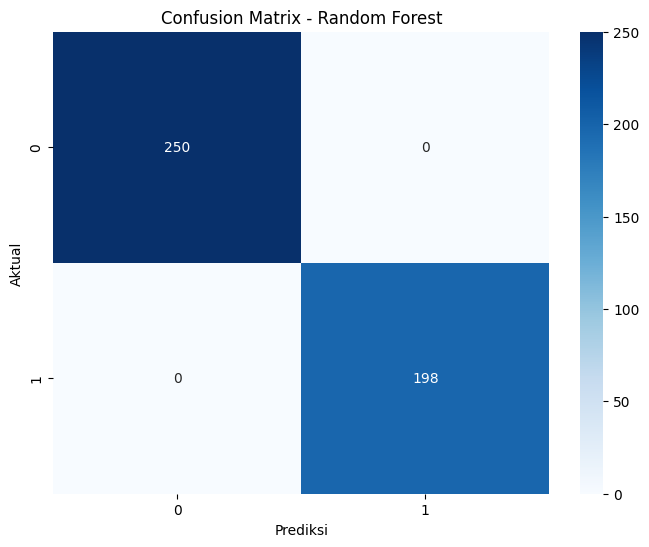

In [19]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test)

rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_f1 = f1_score(y_test, rf_predictions, average='weighted')

print("--- [Hasil Evaluasi Model Random Forest] ---")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"F1 Score: {rf_f1:.4f}")
print("\nLaporan Klasifikasi:")
print(classification_report(y_test, rf_predictions))

rf_cm = confusion_matrix(y_test, rf_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

### **3.2. Model 2: Logistic Regression**

Logistic Regression adalah model linear yang sederhana, cepat, dan mudah diinterpretasikan. Model ini bekerja lebih baik dengan data yang telah distandarisasi.

--- [Hasil Evaluasi Logistic Regression] ---
Accuracy: 1.0000
F1 Score: 1.0000

Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       250
           1       1.00      1.00      1.00       198

    accuracy                           1.00       448
   macro avg       1.00      1.00      1.00       448
weighted avg       1.00      1.00      1.00       448



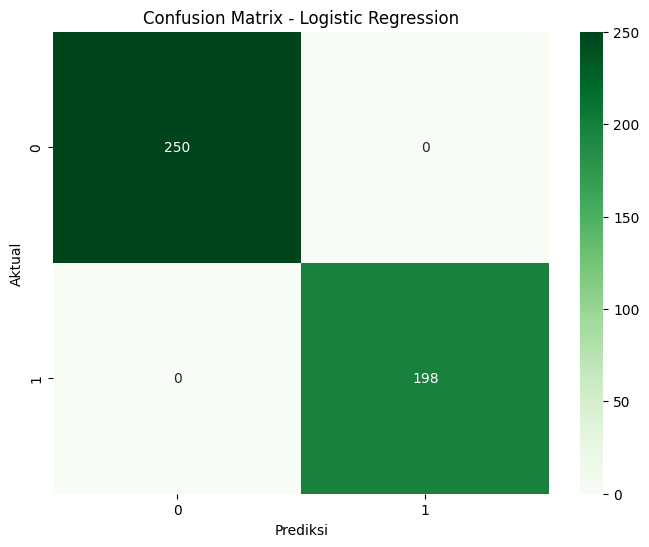

In [20]:
lr_model = LogisticRegression(max_iter=2000, random_state=42, solver='lbfgs', class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)

lr_predictions = lr_model.predict(X_test_scaled)

lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_f1 = f1_score(y_test, lr_predictions, average='weighted')

print("--- [Hasil Evaluasi Logistic Regression] ---")
print(f"Accuracy: {lr_accuracy:.4f}")
print(f"F1 Score: {lr_f1:.4f}")
print("\nLaporan Klasifikasi:")
print(classification_report(y_test, lr_predictions))

lr_cm = confusion_matrix(y_test, lr_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Greens', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

### **3.3. Tuning Model (Opsional)**

Seperti pada notebook aslimu, kita bisa melakukan tuning untuk mencari hyperparameter terbaik. Karena performa Random Forest sudah sempurna, tuning tidak akan memberikan peningkatan signifikan, namun ini adalah praktik yang baik untuk didemonstrasikan.

In [21]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1,
                           verbose=2,
                           scoring='accuracy')

print("\nMemulai proses tuning hyperparameter untuk Random Forest...")
grid_search.fit(X_train, y_train)
print(f"Parameter terbaik ditemukan: {grid_search.best_params_}")

best_rf_model = grid_search.best_estimator_
tuned_predictions = best_rf_model.predict(X_test)
print("\nHasil Evaluasi Random Forest (Setelah Tuning):")
print(classification_report(y_test, tuned_predictions))


Memulai proses tuning hyperparameter untuk Random Forest...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Parameter terbaik ditemukan: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}

Hasil Evaluasi Random Forest (Setelah Tuning):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       250
           1       1.00      1.00      1.00       198

    accuracy                           1.00       448
   macro avg       1.00      1.00      1.00       448
weighted avg       1.00      1.00      1.00       448



## **4. Kesimpulan**

In [22]:
results = {
    'Model': ['Random Forest', 'Logistic Regression'],
    'Accuracy': [rf_accuracy, lr_accuracy],
    'F1 Score': [rf_f1, lr_f1]
}
results_df = pd.DataFrame(results)

print("Perbandingan Hasil Model Klasifikasi:")
display(results_df)

Perbandingan Hasil Model Klasifikasi:


,Model,Accuracy,F1 Score
0,Random Forest,1.0,1.0
1,Logistic Regression,1.0,1.0


Berdasarkan hasil evaluasi, kedua model menunjukkan performa yang sangat luar biasa.

- **Random Forest** mencapai akurasi dan F1-score sempurna **1.0000**, yang menandakan model ini mampu memprediksi segmen pelanggan tanpa ada kesalahan sama sekali pada data uji. Ini menunjukkan bahwa fitur-fitur yang ada sangat informatif dan mampu memisahkan kedua cluster dengan jelas.
- **Logistic Regression** juga menunjukkan performa yang sangat tinggi dengan akurasi **1.0000** dan F1-score **1.0000**. Tidak ada kesalahan prediksi dari total 448 data uji.

Secara keseluruhan, **Random Forest** adalah model terbaik untuk kasus ini karena performanya yang sempurna. Namun, performa Logistic Regression yang sempurna juga menunjukkan bahwa hubungan antara fitur dan target kemungkinan besar dapat ditangkap dengan baik oleh model linear setelah dilakukan standarisasi.